In [27]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt



In [30]:
from pandas import read_table, read_csv
hcc_data = pd.read_csv("hcc_dataset.csv",sep=",")

In [32]:
#* Mostra um pouco do dataset
print("First few rows of the dataset:")
print(hcc_data.head())

First few rows of the dataset:
   Gender Symptoms Alcohol HBsAg HBeAg HBcAb HCVAb Cirrhosis Endemic Smoking  \
0    Male       No     Yes    No    No    No    No       Yes      No     Yes   
1  Female        ?      No    No    No    No   Yes       Yes       ?       ?   
2    Male       No     Yes   Yes    No   Yes    No       Yes      No     Yes   
3    Male      Yes     Yes    No    No    No    No       Yes      No     Yes   
4    Male      Yes     Yes   Yes    No   Yes    No       Yes      No     Yes   

  Diabetes Obesity Hemochro  AHT  CRI HIV NASH Varices Spleno  PHT PVT  \
0      Yes       ?      Yes   No   No  No   No     Yes     No   No  No   
1      Yes      No       No  Yes   No  No   No     Yes     No   No  No   
2       No      No       No  Yes  Yes  No   No      No     No  Yes  No   
3      Yes      No       No  Yes   No  No   No      No     No   No  No   
4       No      No       No  Yes  Yes  No   No      No     No   No  No   

  Metastasis Hallmark  Age Grams_day Packs_

we have:
165 patients
49 features

The first 23 features are categorical, and 26 numeric features
Our target features is "Class" wich will determine the outcome of our analysis. (1 if the patience survives and 0 if the patient dies)


In [33]:
print("\nSummary statistics:")
print(hcc_data.describe(include='all'))


Summary statistics:
       Gender Symptoms Alcohol HBsAg HBeAg HBcAb HCVAb Cirrhosis Endemic  \
count     165      165     165   165   165   165   165       165     165   
unique      2        3       2     3     3     3     3         2       3   
top      Male      Yes     Yes    No    No    No    No       Yes      No   
freq      133       94     122   132   125   103   122       149     116   
mean      NaN      NaN     NaN   NaN   NaN   NaN   NaN       NaN     NaN   
std       NaN      NaN     NaN   NaN   NaN   NaN   NaN       NaN     NaN   
min       NaN      NaN     NaN   NaN   NaN   NaN   NaN       NaN     NaN   
25%       NaN      NaN     NaN   NaN   NaN   NaN   NaN       NaN     NaN   
50%       NaN      NaN     NaN   NaN   NaN   NaN   NaN       NaN     NaN   
75%       NaN      NaN     NaN   NaN   NaN   NaN   NaN       NaN     NaN   
max       NaN      NaN     NaN   NaN   NaN   NaN   NaN       NaN     NaN   

       Smoking Diabetes Obesity Hemochro  AHT  CRI  HIV NASH Varic

In [7]:
df.shape

(165, 50)

In [34]:
print("\nMissing values in the dataset:")
print(hcc_data.isnull().sum())


Missing values in the dataset:
Gender              0
Symptoms            0
Alcohol             0
HBsAg               0
HBeAg               0
HBcAb               0
HCVAb               0
Cirrhosis           0
Endemic             0
Smoking             0
Diabetes            0
Obesity             0
Hemochro            0
AHT                 0
CRI                 0
HIV                 0
NASH                0
Varices             0
Spleno              0
PHT                 0
PVT                 0
Metastasis          0
Hallmark            0
Age                 0
Grams_day           0
Packs_year          0
PS                  0
Encephalopathy    142
Ascites           109
INR                 0
AFP                 0
Hemoglobin          0
MCV                 0
Leucocytes          0
Platelets           0
 Albumin            0
Total_Bil           0
ALT                 0
AST                 0
GGT                 0
ALP                 0
TP                  0
Creatinine          0
Nodules             0


We found 151 missing data, since we don't have enough patients with complete data to make an accurate prediction, we cannot eliminate this, therefore we need to implement techniques to fill in these spaces.

we have 10,22% of missing data and only 4,85% of patients with complete data (8 patients)

In [35]:
target_column = hcc_data.columns[-1]
print(f"\nDistribution of the target variable '{target_column}':")
print(hcc_data[target_column].value_counts())


Distribution of the target variable 'Class':
Class
Lives    102
Dies      63
Name: count, dtype: int64


In [36]:
#! Separa features e target, com o intuito de não generalizar apenas
#? Features são os valores de input, usados para fazer o predict
#? Target é o output que você deseja fazer o predict
X = hcc_data.drop(columns=[target_column])
y = hcc_data[target_column]

In [37]:
#! Diferencia as colunas entre numericas e categoricas
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

In [38]:
#? Prepocessing de valores numericos de data, ignora os nulos 
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [39]:
#? Prepocessing das classes do arquivo csv
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [40]:
#? Combina os passos de prepocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [41]:
#! RandomForest com balanceamento de classe
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])


In [42]:
#! KNeighborsClassifier com possibilidade de ajuste de hiperparâmetros
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=5))  # Ajuste o número de vizinhos se necessário
])

In [43]:
#? Divide o modelo em teste e traino = 70% -> Treino, 30 -> Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [75]:
#! Treino e avaliação para RandomForest
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Age'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Gender', 'Symptoms', 'Alcohol', 'HBsAg', 'H...
       'Metastasis', 'Hallmark', 'Grams_day', 'Packs_year', 'PS',
       'Encephalopathy', 'Ascites', 'INR', 'AFP', 'Hemoglobin', 'MCV',
       'Leucocytes', 'Platelets', ' Albumin', 'Total_Bil', 'ALT', 'AST', 'GGT',
       'ALP', 'TP', 'Creatinine', 'Nodules', 'Major_Dim', 'Dir_Bil', 'Iron',
       'Sat', 'Ferritin'],
      dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [77]:
y_preds_rf = rf_pipeline.predict(X_test)

In [78]:
print("\nRandom Forest Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_preds_rf))
print("ROC AUC:", roc_auc_score(y_test, rf_pipeline.predict_proba(X_test)[:, 1]))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_preds_rf))
print("Classification Report:\n", classification_report(y_test, y_preds_rf))


Random Forest Model Evaluation:
Accuracy: 0.68
ROC AUC: 0.7727272727272728
Confusion Matrix:
 [[ 9 13]
 [ 3 25]]
Classification Report:
               precision    recall  f1-score   support

        Dies       0.75      0.41      0.53        22
       Lives       0.66      0.89      0.76        28

    accuracy                           0.68        50
   macro avg       0.70      0.65      0.64        50
weighted avg       0.70      0.68      0.66        50



In [79]:
#! Treino e avaliação para KNN
knn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Age'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Gender', 'Symptoms', 'Alcohol', 'HBsAg', 'H...
       'AHT', 'CRI', 'HIV', 'NASH', 'Varices', 'Spleno', 'PHT', 'PVT',
       'Metastasis', 'Hallmark', 'Grams_day', 'Packs_year', 'PS',
       'Encephalopathy', 'Ascites', 'INR', 'AFP', 'Hemoglobin', 'MCV',
       'Leucocytes', 'Platelets', ' Albumin', 'Total_Bil', 'ALT', 'AST', 'GGT',
       'ALP', 'TP', 'Creatinine', 'Nodules', 'Major_Dim', 'Dir_Bil', 'Iron',
       'Sat', 'Ferritin'],
      dtype='object'))])),
                ('classifier', KNeighborsClassifier())])

In [80]:
y_preds_knn = knn_pipeline.predict(X_test)

In [81]:
print("\nKNN Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_preds_knn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_preds_knn))
print("Classification Report:\n", classification_report(y_test, y_preds_knn))


KNN Model Evaluation:
Accuracy: 0.68
Confusion Matrix:
 [[ 9 13]
 [ 3 25]]
Classification Report:
               precision    recall  f1-score   support

        Dies       0.75      0.41      0.53        22
       Lives       0.66      0.89      0.76        28

    accuracy                           0.68        50
   macro avg       0.70      0.65      0.64        50
weighted avg       0.70      0.68      0.66        50



In [53]:
# Extrai pontuações de importância dos fetures do modelo treinado
feature_importances = rf_pipeline.steps[-1][1].feature_importances_

In [66]:
# Print feature names and importances
print("Feature Importances:")
for feature, importance in zip(X.columns, feature_importances):
    print(f"{feature}: {importance:.4f}")


Feature Importances:
Gender: 0.0203
Symptoms: 0.0013
Alcohol: 0.0007
HBsAg: 0.0025
HBeAg: 0.0100
HBcAb: 0.0279
HCVAb: 0.0011
Cirrhosis: 0.0036
Endemic: 0.0018
Smoking: 0.0043
Diabetes: 0.0018
Obesity: 0.0047
Hemochro: 0.0021
AHT: 0.0018
CRI: 0.0024
HIV: 0.0021
NASH: 0.0023
Varices: 0.0022
Spleno: 0.0033
PHT: 0.0020
PVT: 0.0022
Metastasis: 0.0015
Hallmark: 0.0056
Age: 0.0018
Grams_day: 0.0028
Packs_year: 0.0012
PS: 0.0016
Encephalopathy: 0.0000
Ascites: 0.0075
INR: 0.0083
AFP: 0.0036
Hemoglobin: 0.0009
MCV: 0.0026
Leucocytes: 0.0119
Platelets: 0.0096
 Albumin: 0.0014
Total_Bil: 0.0000
ALT: 0.0030
AST: 0.0049
GGT: 0.0000
ALP: 0.0024
TP: 0.0043
Creatinine: 0.0004
Nodules: 0.0021
Major_Dim: 0.0009
Dir_Bil: 0.0021
Iron: 0.0008
Sat: 0.0007
Ferritin: 0.0064


For a future analysis of these data taking into account the feature importance in our data, corralated with our target column, 
we can drop those columns to get cleaner information. Such as:

Encephalopathy: 0.0000
Total_Bil: 0.0000
Hemoglobin: 0.0009
Major_Dim: 0.0009
Iron: 0.0008
Sat: 0.0007
Creatinine: 0.0004

We would recommend firstly to drop (Encephalopathy and Total_Bil) since their both in zeros, and see the change in prediction,
and then drop the others and check the accuracy of the model. Taking into account that since not all the features are in zero correletion 
with the class feature, in a greater data set that correlation could be bigger, and may have a greater impact. 

Therefore, to avoid overfitting we should only drop those with zero importance.

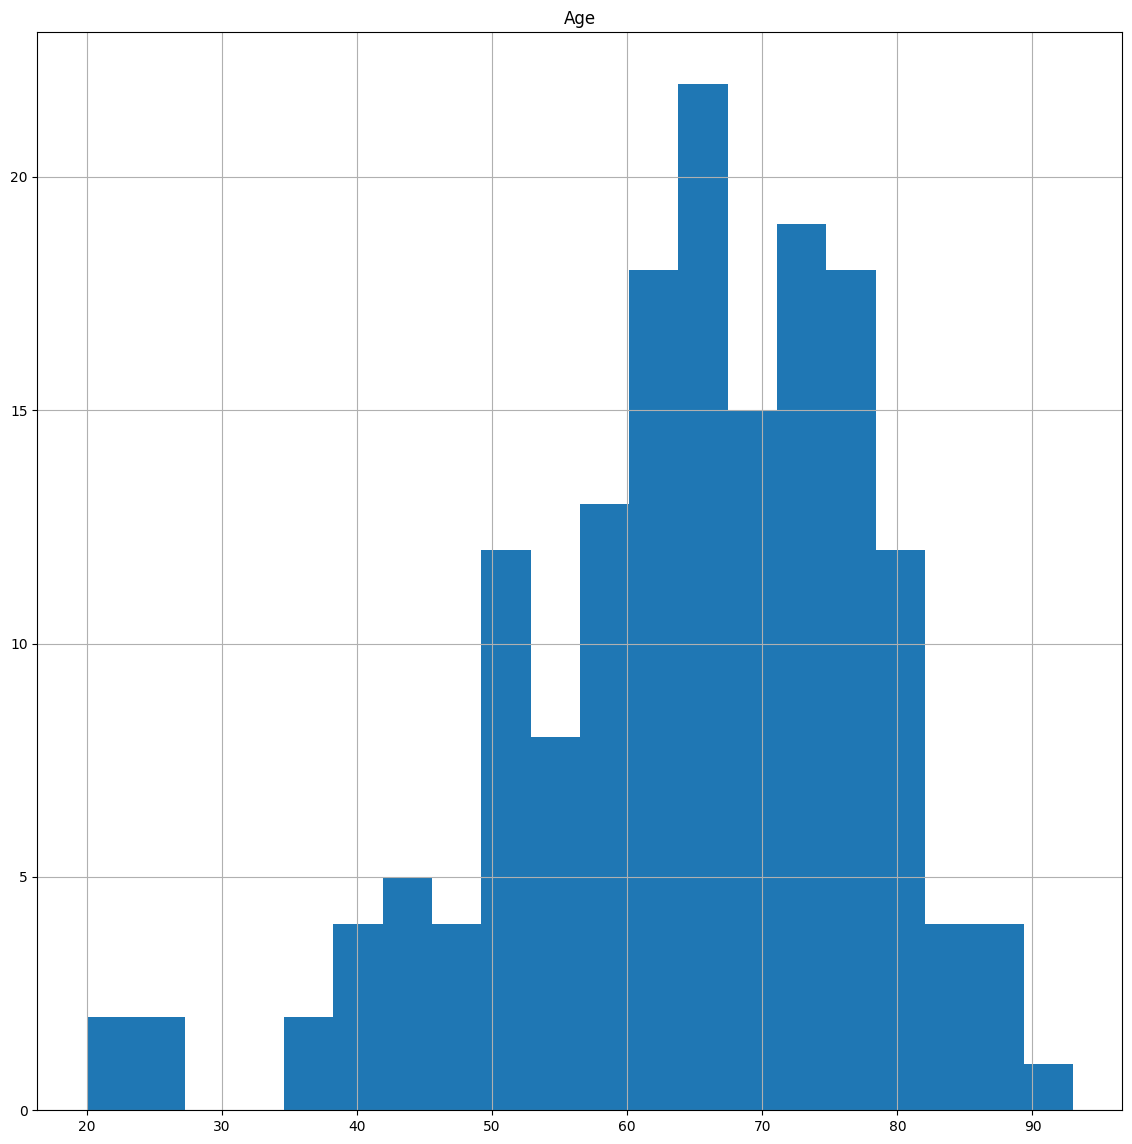

In [60]:
#? Histograma das colunas numéricas
hcc_data[numerical_cols].hist(figsize=(14, 14), bins=20)
plt.show()

Interpretation of Results:
The Random Forest Classifier has been trained and evaluated. The accuracy and ROC AUC scores provide a measure of the model's performance.
The confusion matrix and classification report give detailed insights into the performance metrics such as precision, recall, and F1-score.
Further analysis and hyperparameter tuning could be conducted to improve the model performance. Additionally, other classifiers and techniques can be explored for better results.

For future improvements, we could apply feature engineering by creating new features based on existing ones that may be related 
between them.

We could try to enhance our model performance by tunning our hyperparameters with different algorithms, 
always being aware of avoiding overfitting.

We could also implement cross validation with diferent folds to make sure our model can handdle diferent data, and is not overfitted.